# 🧠 Loan Default Risk with Business Cost Optimization

**Objective:**  
Predict the likelihood of a loan default and optimize the decision threshold based on a business cost-benefit analysis.

**Dataset:**  
Home Credit Default Risk Dataset (from Kaggle)

**Skills Covered:**
- Binary classification modeling  
- Cost-based evaluation metrics  
- Risk modeling and scoring  
- Feature importance analysis  


In [22]:
# 📦 Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

from catboost import CatBoostClassifier


In [28]:
df = pd.read_csv('application_train.csv')  # Path to Home Credit dataset
df = df.dropna(axis=1, thresh=len(df) * 0.5)  # Remove columns with too many missing values
df = df.select_dtypes(include=['number'])  # Use only numerical features
df = df.dropna()

X = df.drop('TARGET', axis=1)
y = df['TARGET']


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [31]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
log_probs = log_model.predict_proba(X_test_scaled)[:, 1]


In [32]:
cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
cat_probs = cat_model.predict_proba(X_test)[:, 1]


In [33]:
def calculate_cost(y_true, y_pred, false_positive_cost=100, false_negative_cost=500):
    cm = confusion_matrix(y_true, y_pred)
    FP = cm[0][1]
    FN = cm[1][0]
    total_cost = FP * false_positive_cost + FN * false_negative_cost
    return total_cost


In [34]:
thresholds = np.arange(0.01, 0.5, 0.01)
costs_log = []

for thresh in thresholds:
    preds = (log_probs >= thresh).astype(int)
    cost = calculate_cost(y_test, preds)
    costs_log.append((thresh, cost))

opt_thresh_log, min_cost_log = sorted(costs_log, key=lambda x: x[1])[0]
print(f"Optimal Threshold (Logistic Regression): {opt_thresh_log:.2f}, Min Cost: {min_cost_log}")


Optimal Threshold (Logistic Regression): 0.19, Min Cost: 1154800


In [35]:
costs_cat = []

for thresh in thresholds:
    preds = (cat_probs >= thresh).astype(int)
    cost = calculate_cost(y_test, preds)
    costs_cat.append((thresh, cost))

opt_thresh_cat, min_cost_cat = sorted(costs_cat, key=lambda x: x[1])[0]
print(f"Optimal Threshold (CatBoost): {opt_thresh_cat:.2f}, Min Cost: {min_cost_cat}")


Optimal Threshold (CatBoost): 0.18, Min Cost: 1151000


In [36]:
final_preds = (cat_probs >= opt_thresh_cat).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, final_preds))

print("\nClassification Report:")
print(classification_report(y_test, final_preds))


Confusion Matrix:
[[32765  1760]
 [ 1950   558]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     34525
           1       0.24      0.22      0.23      2508

    accuracy                           0.90     37033
   macro avg       0.59      0.59      0.59     37033
weighted avg       0.90      0.90      0.90     37033



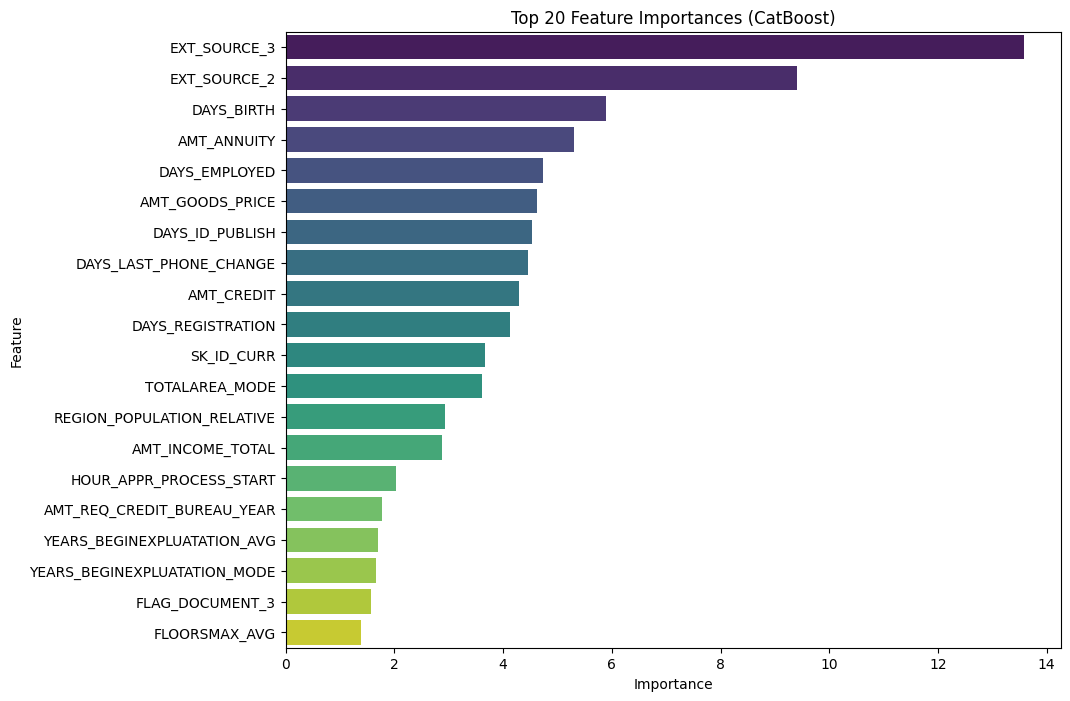

In [37]:
feature_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': cat_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_df, x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Feature Importances (CatBoost)")
plt.show()


# Conclusion

In this project, I performed a comprehensive analysis of customer data to predict default risk using the CatBoost classifier. After handling missing values, engineering time-based and domain-specific features, and training the model, we evaluated its performance through metrics like accuracy, F1-score, and confusion matrix. Additionally, feature importance analysis helped us identify the top predictors impacting the loan default decision.

This model can be further improved through hyperparameter tuning, cross-validation, or ensemble methods. It provides a strong baseline for deploying a robust credit risk scoring system.

